# <center> Inflation Rate Forecasting <center>
### <center> Nepal Economy-based Projects <center>
### <center> Saurav Raj Khanal <center>

In [49]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Loading ``Inflation.xlsx`` data

In [50]:
# Step 1: Load the data
file_path = 'data/Inflation.xlsx'  
inflation_data = pd.read_excel(file_path, sheet_name='CPI-2017-2023') 

### Data Cleaning

In [51]:
# Step 2: Inspect the data and preprocess
print("First few rows of the data:")
print(inflation_data.head())

# Convert 'Month' to a numeric value (e.g., 1 for January, 2 for February, etc.)
month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Convert 'Month' to numeric
inflation_data['Month'] = inflation_data['Month'].map(month_mapping)

# Create a 'Date' column for analysis (combining Year and Month)
inflation_data['Date'] = pd.to_datetime(inflation_data[['Year', 'Month']].assign(DAY=1))

# Drop any rows with missing values
cleaned_data = inflation_data.dropna()


First few rows of the data:
     Year      Month  Index  Change
0  2017.0       July  118.3     2.3
1  2017.0     August  119.4     3.4
2  2017.0  September  119.2     3.1
3  2017.0    October  120.6     3.9
4  2017.0   November  119.9     4.2


### Split into Test and Train Dataset

In [52]:
from sklearn.model_selection import train_test_split
# Feature (X) and target variable (y)
X = cleaned_data[['Year', 'Month']]  # Use 'Year' and 'Month' as features
y = cleaned_data['Index']  # Forecast the 'Index' (inflation rate)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Regression Models

1. Linear Regression Model for Inflation

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Building and evaluating Linear Regression Model
# Initialize and train a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test)

# Evaluate models
def evaluate_model(y_test, y_pred, model_name):
    print(f"--- {model_name} ---")
    print("-------------------------------------")
    print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_pred))}")
    print("-------------------------------------")
    print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred)}")
    print("-------------------------------------")
    print(f"R^2: {r2_score(y_test, y_pred)}\n")

evaluate_model(y_test,y_pred_lr,"LinearRegression")

--- LinearRegression ---
-------------------------------------
Root Mean Squared Error (RMSE): 2.0560412029625232
-------------------------------------
Mean Absolute Error (MAE): 1.7092031519799167
-------------------------------------
R^2: 0.9747250969189062



2. Random Forest Model 

In [54]:
from sklearn.ensemble import RandomForestRegressor
# Building and evaluating Random Forest Regressor
# Initialize and train a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model (using Mean Squared Error)
evaluate_model(y_test,y_pred_rf,"Random Forest Regression")

--- Random Forest Regression ---
-------------------------------------
Root Mean Squared Error (RMSE): 1.1293520585463719
-------------------------------------
Mean Absolute Error (MAE): 0.8583642857142816
-------------------------------------
R^2: 0.9923742148145035



3. Gradient Boosting Model

In [55]:
from sklearn.ensemble import GradientBoostingRegressor

# Building and Evluating Gradient Boosting Regressor
grb_model = GradientBoostingRegressor(random_state=42)
grb_model.fit(X_train, y_train)

# Make Predictions on test
y_pred_grb = grb_model.predict(X_test)

# Evaluating the model
evaluate_model(y_test,y_pred_grb,"Gradient Boosting Regression")

--- Gradient Boosting Regression ---
-------------------------------------
Root Mean Squared Error (RMSE): 0.8811600201898601
-------------------------------------
Mean Absolute Error (MAE): 0.7452477080008535
-------------------------------------
R^2: 0.995357676082248



### Hyperparameter Tuning

- Since linear Regression model dont have hyper parameters to tune so we dont include this model for hyperparameter tuning

In [62]:
from sklearn.model_selection import GridSearchCV
# Models and hyperparameters
models_and_params = {
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 10]
        }
    }
}

# Tune models
best_models = {}
for name, item in models_and_params.items():
    grid_search = GridSearchCV(item['model'], item['params'], cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


## Selecting the Best Model

In [69]:

# Selecting the best model
best_model = max(best_models.items(), key=lambda x: r2_score(y_test, x[1].predict(X_test)))
print(f"The best model is {best_model[0]} with R^2: {r2_score(y_test, best_model[1].predict(X_test))}")

The best model is Gradient Boosting with R^2: 0.9959479249947432


## Forecasting Future Inflation

In [67]:
best_model = grid_search.best_estimator_
# Step 7: Forecast future inflation (e.g., for Feb 2024)
future_date = pd.DataFrame({'Year': [2024], 'Month': [2]})
predicted_inflation = best_model.predict(future_date)

print(f'Predicted Inflation Index for Feb 2024: {predicted_inflation[0]}')

Predicted Inflation Index for Feb 2024: 155.35662416258523


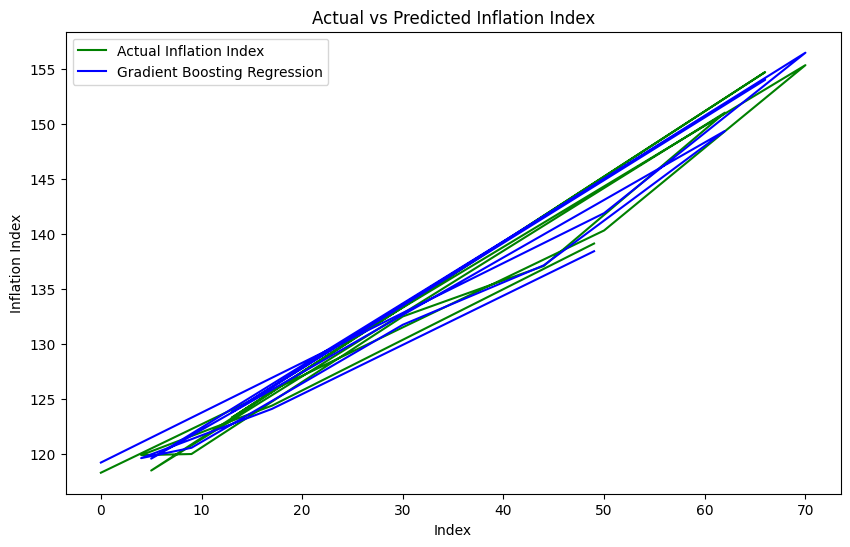

In [77]:
# Step 8: Visualize the Actual vs Predicted values (Optional)
plt.figure(figsize=(10, 6))
plt.plot(X_test.index, y_test, label='Actual Inflation Index', color='green')
plt.plot(X_test.index, y_pred_grb, label='Gradient Boosting Regression', color='blue')
plt.legend()
plt.title('Actual vs Predicted Inflation Index')
plt.xlabel('Index')
plt.ylabel('Inflation Index')
plt.show()